<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/Reinforcement/Reasoning%20%7BRL%7D%20-%204%3A%20Deep-Q%20Convolution%20nw%20(Value%20based%20nw).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Refrences
https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-4-deep-q-networks-and-beyond-8438a3e2b8df

https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%204%20-%20Deep%20Q-Networks%20and%20Beyond%20with%20Keras.ipynb  -- Keras

https://github.com/awjuliani/DeepRL-Agents/blob/master/Double-Dueling-DQN.ipynb -- Tensorflow


Instead of a single layer perceptron or policy based n/w, we will be implmenting DeepQ N/w which are value based learners meaning in bellmon equation we will be learning the value of a given state + advantage of moving from a givent state when some action is performed which is different from policy based n/w where we just update n/w weight and dont care about value of states. 

**Value function V(s)** - which says simple how good network thinks it is in current state. 

**Advantage function A(a)** - which tells how much better taking a certain action would be compared to the others.

Q(s,a) = V(s) + A(a)   # This Equation will be used heavenly below.


### Changes



*   **Deep Q - convolution layers**  - here we will consider our input as an image where the whole image is a state and our n/w  will use convolution to know the meaning of states. 
*   **Experiance Relay** - We will be storing the states into a buffer and later we will sample the buffer to train our n/w on past experiances rather then immediate ones. The size of buffer is limited and is Queue based meaning only recent experiances are retained.
*   **Separate Target n/w** - We will have 2 n/w, 1st will generate Q-output values and 2nd will generate target Q values for loss calculations. The frequency of update for 2nd n/w is low compared to 1st, to help stablization. As if 2nd n/w value change whch are used to traing estimate Q values for each iteration system will never get stable 1 needed to be fixed (for certain duration).


### Env

Grid World Env, no need to study code.

In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1).


In [0]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
from PIL import Image

class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name
        
class gameEnv():
    def __init__(self,partial,size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        self.partial = partial
        
        a = self.reset()
        plt.imshow(a,interpolation="nearest")
        
        
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        bug = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug)
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole)
        bug2 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug2)
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole2)
        bug3 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug3)
        bug4 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(bug4)
        state = self.renderEnv()
        self.state = state
        return state

    def moveChar(self,direction):
        # 0 - up, 1 - down, 2 - left, 3 - right
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        penalize = 0.
        if direction == 0 and hero.y >= 1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >= 1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1     
        if hero.x == heroX and hero.y == heroY:
            penalize = 0.0
        self.objects[0] = hero
        return penalize
    
    def newPosition(self):
        iterables = [ range(self.sizeX), range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if (objectA.x,objectA.y) not in currentPositions:
                currentPositions.append((objectA.x,objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)),replace=False)
        return points[location]

    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        ended = False
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else: 
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                return other.reward,False
        if ended == False:
            return 0.0,False

    def renderEnv(self):
        #a = np.zeros([self.sizeY,self.sizeX,3])
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        hero = None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1,item.x+1:item.x+item.size+1,item.channel] = item.intensity
            if item.name == 'hero':
                hero = item
        if self.partial == True:
            a = a[hero.y:hero.y+3,hero.x:hero.x+3,:]

        # converting a low dimentinal array to an image with high dimention

        ''' Deprecated in scipy '''
#         b = scipy.misc.imresize(a[:,:,0], [84,84,1], interp='nearest')
#         c = scipy.misc.imresize(a[:,:,1], [84,84,1], interp='nearest')
#         d = scipy.misc.imresize(a[:,:,2], [84,84,1], interp='nearest')

        # (7, 7, 3) => (84, 84, 3)
        b = np.array(Image.fromarray(a[:,:,0]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        c = np.array(Image.fromarray(a[:,:,1]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        d = np.array(Image.fromarray(a[:,:,2]).resize((84, 84), Image.NEAREST)).reshape(84, 84)
        
        a = np.stack([b,c,d], axis=2)

        return a

    def step(self,action):
        penalty = self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        if reward == None:
            print(done)
            print(reward)
            print(penalty)
            return state,(reward+penalty),done
        else:
            return state,(reward+penalty),done


## Codebase

In [3]:
from __future__ import division
import gym
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt

import scipy.misc
import os
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



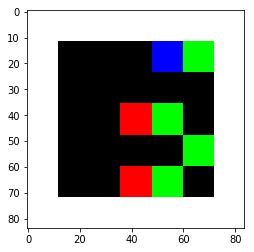

In [4]:
env = gameEnv(partial=False, size=5)

This is the game we'll be working on. The player can move the blue square up, down, left or right. The point of the game is to get to the green square (+1 reward) and avoid the red square (-1 reward). Blocks are randomized


Original shape: (84, 84, 3)
Processed shape: (84, 84, 3)


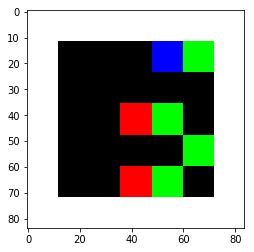

In [5]:
def process_state(state):
    """ This processes the state and converts to black & white. This will help speed up learning
        as the number of parameters will be reduced.
    """
    return state

plt.imshow(process_state(env.state))

print("Original shape: {}".format(env.state.shape))
print("Processed shape: {}".format(process_state(env.state).shape))

### Implemting Deep-Q Convolution n/w

In [6]:
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, Lambda
import keras.backend as K

class Qnetwork():
    def __init__(self, final_layer_size):
        # The input image of the game is 84 x 84 x 3 (RGB) 
        self.inputs = Input(shape=[*process_state(env.state).shape], name="main_input")

        # There will be four layers of convolutions performed on the image input
        # A convolution take a portion of an input and matrix multiplies
        # a filter on the portion to get a new input (see below)
        self.model = Conv2D(filters=32, kernel_size=[8,8], strides=[4,4], activation="relu", padding="valid", name="conv1")(self.inputs)
        self.model = Conv2D(filters=64, kernel_size=[4,4], strides=[2,2], activation="relu", padding="valid", name="conv2")(self.model)
        self.model = Conv2D(filters=64, kernel_size=[3,3], strides=[1,1], activation="relu", padding="valid", name="conv3")(self.model)
        self.model = Conv2D(filters= final_layer_size, kernel_size=[7,7], strides=[1,1], activation="relu",padding="valid", name="conv4")(self.model)
        
        
        # We then separate the final convolution layer into an advantage and value
        # stream, 1/2 weights attached to each.. The value function is how well off you are in a given state.
        # The advantage is the how much better off you are after making a particular
        # move. Q is the value function of a state after a given action.
        # Advantage(state, action) = Q(state, action) - Value(state)

        self.stream_AC = Lambda(lambda layer: layer[:,:,:,:final_layer_size // 2],name="advantage")(self.model)
        self.stream_VC = Lambda(lambda layer: layer[:,:,:,final_layer_size // 2:],name="value")(self.model)
        
        # We then flatten the advantage and value functions
        self.stream_AC = Flatten(name="advantage_flatten")(self.stream_AC)
        self.stream_VC = Flatten(name="value_flatten")(self.stream_VC)
        
        # We define weights for our advantage and value layers. We will train these
        # layers so the matmul will match the expected value and advantage from play
        self.Advantage = Dense(env.actions, name="advantage_final")(self.stream_AC)
        self.Value = Dense(1, name="value_final")(self.stream_VC)

        #Ques - what are we trying to optimize ?? Guess in Keras we dont define target varible and it is passed at training time. (train_on_batch)
        
        # To get the Q output, we need to add the value to the advantage.
        # The advantage to be evaluated will be based on how good the action
        # is based on the average advantage of that state
        self.model = Lambda(lambda x: x[0] + (x[1] - K.mean(x[1], axis=1, keepdims=True)), name="final_out")([self.Value, self.Advantage])
        
        self.model = Model(self.inputs, self.model)
        self.model.compile("adam", "mse")
        self.model.optimizer.lr = 0.0001

Using TensorFlow backend.


In [7]:
main_qn = Qnetwork(512)
target_qn = Qnetwork(512)

In [8]:
main_qn.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 32)   6176        main_input[0][0]                 
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 9, 9, 64)     32832       conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 7, 7, 64)     36928       conv2[0][0]                      
____________________________________________________________________________________________

### Experience Replay
This class allows us to store experiences and sample them randomly for learning

In [0]:
def update_target_graph(main_graph, target_graph, tau):
    updated_weights = (np.array(main_graph.get_weights()) * tau) + (np.array(target_graph.get_weights()) * (1 - tau))
    target_graph.set_weights(updated_weights)
    
class ExperienceReplay:
    def __init__(self,buffer_size=50000):
        """ Data structure used to hold game experiences """
        # Buffer will contain [state,action,reward,next_state,done]
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # Extend the stored experiences
        self.buffer.extend(experience)
        # Keep the last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer), size=size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output, (size, -1))
        return sample_output


### Training the network


In [0]:
batch_size = 64 # How many experiences to use for each training step
num_epochs = 20 # How many epochs to train

update_freq = 5 # How often you update the network
y = 0.99 # Discount factor

prob_random_start = 0.6 # Starting chance of random action
prob_random_end = 0.1 # Ending chance of random action

annealing_steps = 1000. # Steps of training to reduce from start_e -> end_e
num_episodes = 10000 # How many episodes of game environment to train
pre_train_episodes = 100 # Number of episodes of random actions

max_num_step = 75 # Maximum allowed episode length

load_model = False # Whether to load a saved model
path = "./models_1" # Path to save our model to
!rm -rf path
main_weights_file = path + "/main_weights.h5" # File to save our main weights to
target_weights_file = path + "/target_weights.h5" # File to save our target weights to

final_layer_size = 512 # Size of the final convolution layer before 
                       # splitting into Advantage and Value streams
  
tau = 1 # Rate to update target network toward primary network
goal = 25

In [18]:
# Reset everything
K.clear_session()

# Setup our Q-networks
main_qn = Qnetwork(final_layer_size)
target_qn = Qnetwork(final_layer_size)

# Make the networks equal
update_target_graph(main_qn.model, target_qn.model, 1)

# Setup our experience replay
experience_replay = ExperienceReplay()

# We'll begin by acting complete randomly. As we gain experience and improve,
# we will begin reducing the probability of acting randomly, and instead
# take the actions that our Q network suggests
prob_random = prob_random_start
prob_random_drop = (prob_random_start - prob_random_end) / annealing_steps

num_steps = [] # Tracks number of steps per episode
rewards = [] # Tracks rewards per episode
total_steps = 0 # Tracks cumulative steps taken in training

print_every = 50 # How often to print status
save_every = 5 # How often to save

losses = [0] # Tracking training losses

# Setup path for saving
if not os.path.exists(path):
    os.makedirs(path)

if load_model == True:
    if os.path.exists(main_weights_file):
        print("Loading main weights")
        main_qn.model.load_weights(main_weights_file)
    if os.path.exists(target_weights_file):
        print("Loading target weights")
        target_qn.model.load_weights(target_weights_file)

for num_episode in range(num_episodes):

    # Create an experience replay for the current episode
    episode_buffer = ExperienceReplay()

    # Get the game state from the environment
    state = env.reset()

    done = False # Game is complete
    sum_rewards = 0 # Running sum of rewards in episode
    cur_step = 0 # Running sum of number of steps taken in episode

    ''' Save all the interaction with Env '''
    while cur_step < max_num_step and not done:
        cur_step += 1
        total_steps += 1

        if np.random.rand() < prob_random or num_episode < pre_train_episodes:
                # Act randomly based on prob_random or if we
                # have not accumulated enough pre_train episodes
                action = np.random.randint(env.actions)
        else:
            # Decide what action to take from the Q network
            action = np.argmax(main_qn.model.predict(np.array([state])))

        # Take the action and retrieve the next state, reward and done
        state_next, reward, done = env.step(action)
        state_next = process_state(state_next)

        # Setup the episode to be stored in the episode buffer
        episode = np.array([[state], action, reward, [state_next], done])
        episode = episode.reshape(1,-1)

        # Store the experience in the episode buffer
        episode_buffer.add(episode)

        # Update the running rewards
        sum_rewards += reward

        # Update the state
        state = state_next


    if num_episode > pre_train_episodes:
        # Training the network

        if prob_random > prob_random_end:
            # Drop the probability of a random action
            prob_random -= prob_random_drop

        if num_episode % update_freq == 0:
            for num_epoch in range(num_epochs):
              
                ''' Below Bellman equation will run we will use actual experiances from main model and
                will use actual reward + discounted rewards from target model to recalculate value
                
                target_q [action] = actual_reward (main_nw) + discounted_Qvalue (target_nw) 
                
                '''
                # Train batch is [[state,action,reward,next_state,done],...]
                train_batch = experience_replay.sample(batch_size)

                # Separate the batch into its components
                state_m, action_m, reward, state_next_m, done = train_batch.T
                
                # Convert the action array into an array of ints so they can be used for indexing
                action_m = action_m.astype(np.int)

                # Stack the states and train_next_state for learning
                state_m = np.vstack(state_m)
                state_next_m = np.vstack(state_next_m)

                
                ''' 
                In order to train n/w we need output from our target n/w modified with optimum rewards
                Based on Bellmon Equation we know that
                
                Q_out = rewards + discount_factor  * (future_rewards / advantage)
                
                We have rewards and duscount_factor, but advantage are unknown, advantage are just new state values from our target n/w.
                '''
                output_t = target_qn.model.predict(state_m)

                
                # The Q values from our target network from the next state
                output_state_next_m = main_qn.model.predict(state_next_m)
                
                action_state_next_m = np.argmax(output_state_next_m,axis=1).astype(np.int)

                # Q value of the next state based on action
                Qout_state_next_m = output_state_next_m[range(batch_size), action_state_next_m]

                ''''Tells us whether game over or not, We will multiply our rewards by this value to ensure we don't train on the last move '''
                train_gameover = done == 0
                
                # Reward from the action chosen in the train batch
                actual_reward = reward + (y * Qout_state_next_m * train_gameover)
                ''' Remember we are not overriding every value in output_t only the best action q value'''
                output_t[range(batch_size), action_m] = actual_reward

                # Train the main model
                '''
                Ideally we dont need target model, but here we can see that with each update weight will change
                which will contradict with target_q value we will be generating, hence we are keeping target constant but generating from 
                identical but slightly outdated same model copy.
                '''

                loss = main_qn.model.train_on_batch(state_m, output_t)  
                
                losses.append(loss)
                
            # Update the target model with values from the main model
            update_target_graph(main_qn.model, target_qn.model, tau)

            if (num_episode + 1) % save_every == 0:
                # Save the model
                main_qn.model.save_weights(main_weights_file)
                target_qn.model.save_weights(target_weights_file)

    # Increment the episode
    num_episode += 1

    experience_replay.add(episode_buffer.buffer)
    num_steps.append(cur_step)
    rewards.append(sum_rewards)
        
    if num_episode % print_every == 0:
        # Print progress
        mean_loss = np.mean(losses[-(print_every * num_epochs):])

        print("Num episode: {} Mean reward: {:0.4f} Prob random: {:0.4f}, Loss: {:0.04f}".format(
            num_episode, np.mean(rewards[-print_every:]), prob_random, mean_loss))
        if np.mean(rewards[-print_every:]) >= goal:
            print("Training complete!")
            break

Num episode: 50 Mean reward: 3.0000 Prob random: 0.6000, Loss: 0.0000
Num episode: 100 Mean reward: 2.3800 Prob random: 0.6000, Loss: 0.0000
Num episode: 150 Mean reward: 2.0400 Prob random: 0.5755, Loss: 0.0310
Num episode: 200 Mean reward: 3.6800 Prob random: 0.5505, Loss: 0.0290
Num episode: 250 Mean reward: 10.2400 Prob random: 0.5255, Loss: 0.0302
Num episode: 300 Mean reward: 11.8400 Prob random: 0.5005, Loss: 0.0389
Num episode: 350 Mean reward: 15.3200 Prob random: 0.4755, Loss: 0.0539
Num episode: 400 Mean reward: 15.7600 Prob random: 0.4505, Loss: 0.0762
Num episode: 450 Mean reward: 18.8000 Prob random: 0.4255, Loss: 0.1057
Num episode: 500 Mean reward: 19.1200 Prob random: 0.4005, Loss: 0.1406
Num episode: 550 Mean reward: 20.6800 Prob random: 0.3755, Loss: 0.1739
Num episode: 600 Mean reward: 22.3600 Prob random: 0.3505, Loss: 0.2017
Num episode: 650 Mean reward: 22.1800 Prob random: 0.3255, Loss: 0.2228
Num episode: 700 Mean reward: 23.7600 Prob random: 0.3005, Loss: 0.24

In [0]:
main_qn.model.save_weights(main_weights_file)
target_qn.model.save_weights(target_weights_file)

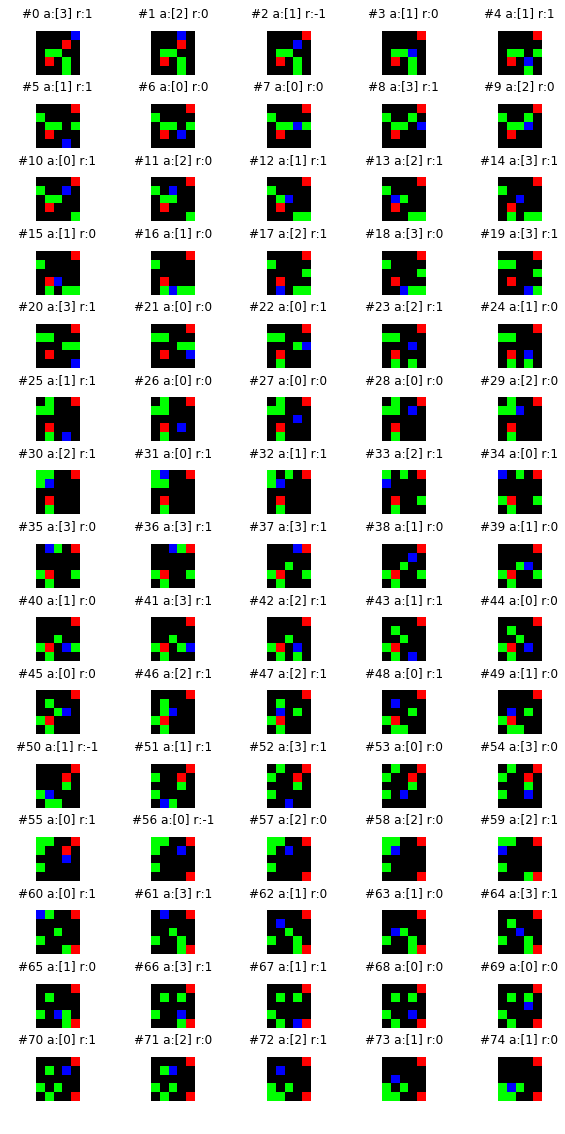

In [20]:
f, axes = plt.subplots(nrows=max_num_step//5, ncols=5, sharex=True, sharey=True, figsize=(10,20))
done = False
num_step = 0
sum_rewards = 0
state = env.reset()
state = process_state(state)

while not done and num_step < max_num_step:
    action = np.argmax(main_qn.model.predict(np.array([state])),axis=1)
    next_state, reward, done = env.step(action)
    state = process_state(next_state)
    ax = axes.ravel()[num_step]    
    ax.imshow(state)
    ax.set_axis_off()
    ax.set_title("#{} a:{} r:{}".format(num_step, action, int(reward)))
    num_step += 1